In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
)

In [ ]:

df_sensor = pd.read_csv("datasets/assignTTSWING_sensor_only.csv")
X = df_sensor.drop(columns=['playYears'])
y = df_sensor['playYears']
classes = np.unique(y)
n_classes = len(classes)

rows, columns = df_sensor.shape

print(f"Rows: {rows}, Columns: {columns}")
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Rows: 87101, Columns: 39


In [ ]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


accuracies, precisions, recalls, f1s = [], [], [], []
conf_matrices = []
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}
models = [] 

for fold, (train_index, test_index) in enumerate(skf.split(X_scaled, y), 1):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LogisticRegression(
        penalty=None,
        solver='lbfgs',
        multi_class='multinomial',
        class_weight='balanced',
        max_iter=1000
    )
    model.fit(X_train, y_train)
    models.append(model)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)


    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))
    conf_matrices.append(confusion_matrix(y_test, y_pred))


    y_test_bin = label_binarize(y_test, classes=classes)

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        fpr_dict.setdefault(i, []).append(fpr)
        tpr_dict.setdefault(i, []).append(tpr)
        roc_auc_dict.setdefault(i, []).append(auc(fpr, tpr))


print("\n===== Average Results over 5 Folds =====")
print(f"Mean Accuracy:  {np.mean(accuracies):.4f}")
print(f"Mean Precision: {np.mean(precisions):.4f}")
print(f"Mean Recall:    {np.mean(recalls):.4f}")
print(f"Mean F1 Score:  {np.mean(f1s):.4f}")

c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\sklearn\linear_model\_logistic.py


===== Average Results over 5 Folds =====
Mean Accuracy:  0.5006
Mean Precision: 0.5183
Mean Recall:    0.5637
Mean F1 Score:  0.5016


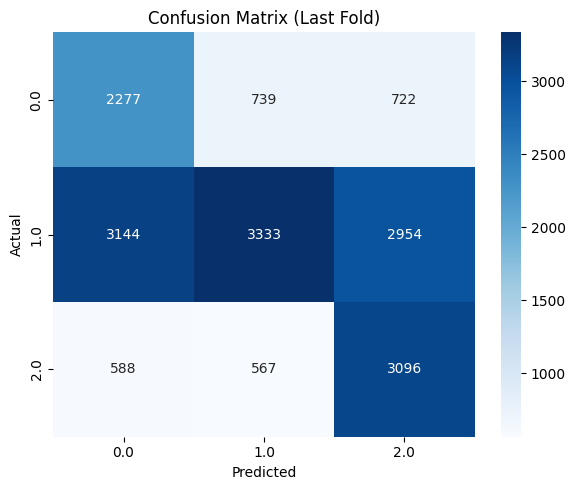

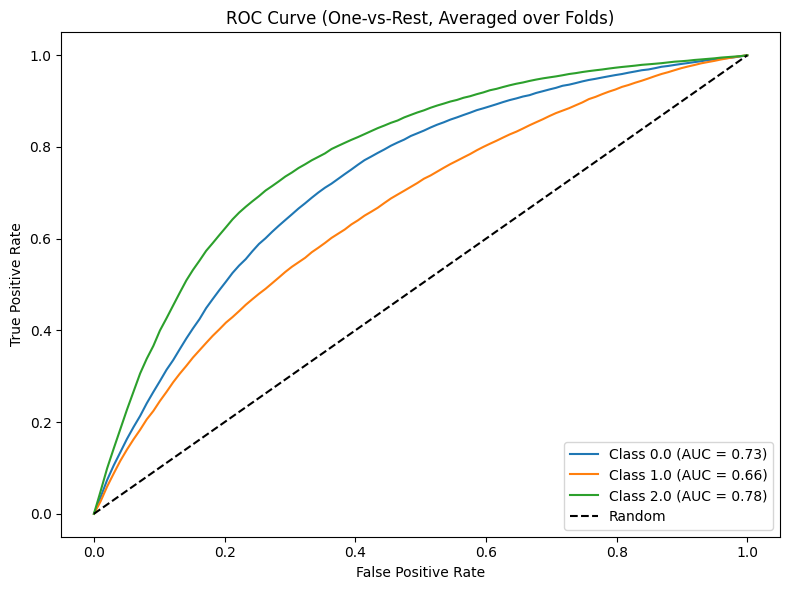

In [ ]:


plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrices[-1], annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (Last Fold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
for i in range(n_classes):
    mean_fpr = np.linspace(0, 1, 100)
    interp_tprs = []
    for fpr, tpr in zip(fpr_dict[i], tpr_dict[i]):
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        interp_tprs.append(interp_tpr)
    mean_tpr = np.mean(interp_tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, label=f"Class {classes[i]} (AUC = {mean_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest, Averaged over Folds)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

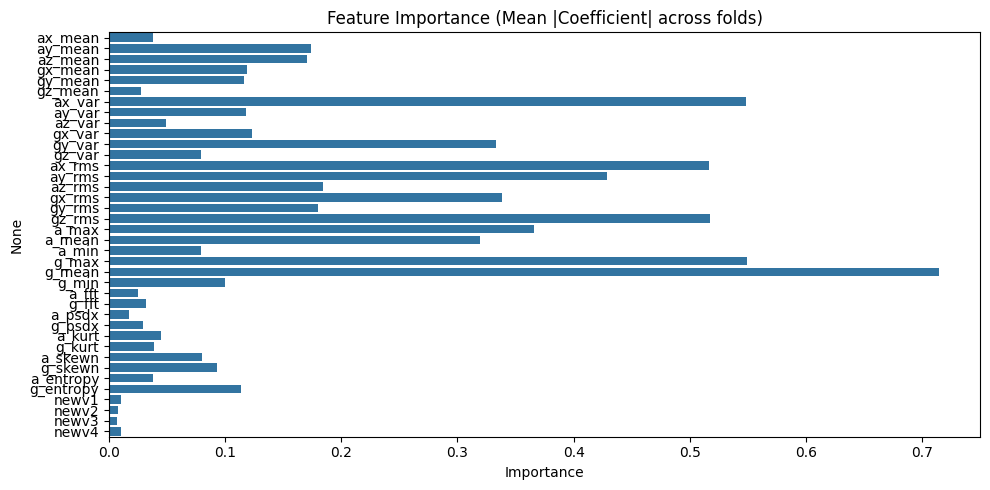

In [ ]:
avg_coef = np.mean([np.abs(model.coef_) for model in models], axis=0)  
mean_importance = np.mean(avg_coef, axis=0)

plt.figure(figsize=(10, 5))
sns.barplot(x=mean_importance, y=X.columns)
plt.title("Feature Importance (Mean |Coefficient| across folds)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


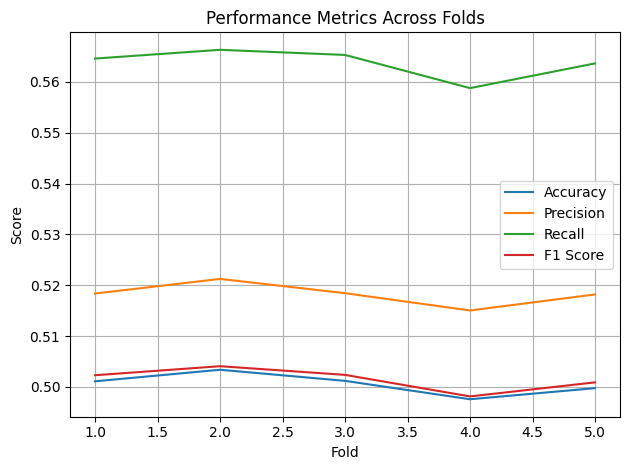

In [14]:
folds = range(1, 6)
plt.plot(folds, accuracies, label="Accuracy")
plt.plot(folds, precisions, label="Precision")
plt.plot(folds, recalls, label="Recall")
plt.plot(folds, f1s, label="F1 Score")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("Performance Metrics Across Folds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


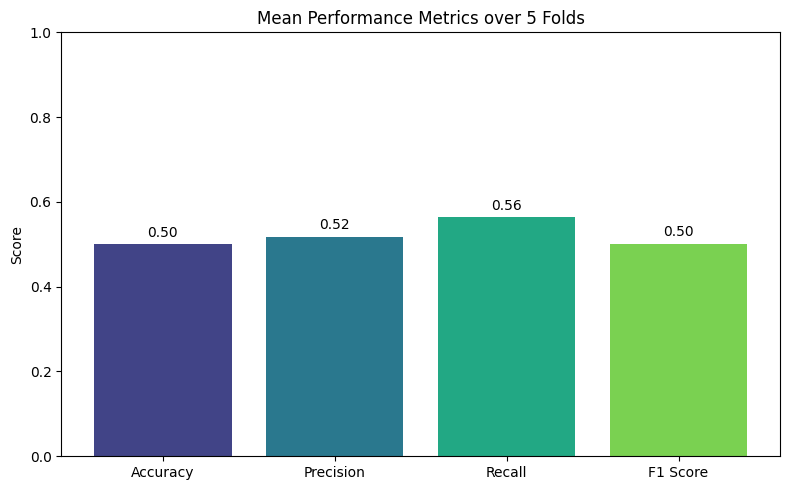

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [0.5006, 0.5183, 0.5637, 0.5016]


colors = sns.color_palette("viridis", len(metrics))


plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=colors)
plt.ylim(0, 1)
plt.title("Mean Performance Metrics over 5 Folds")
plt.ylabel("Score")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

C_values = [0.001, 0.01, 0.1, 1, 10, 100]
mean_scores = []

for c in C_values:
    model = LogisticRegression(C=c, penalty='l2', solver='liblinear', max_iter=1000)
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
    mean_scores.append(np.mean(scores))


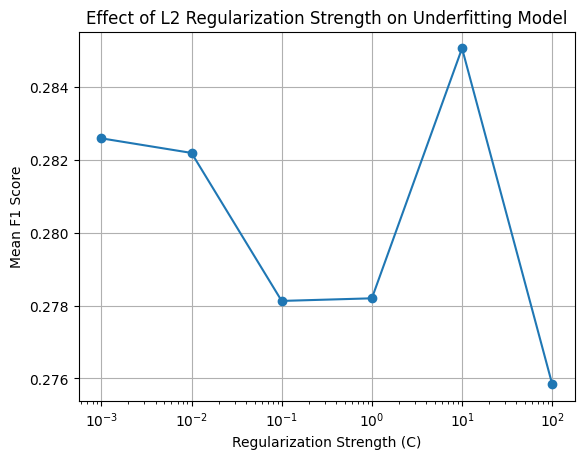

In [18]:
import matplotlib.pyplot as plt

plt.plot(C_values, mean_scores, marker='o')
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Mean F1 Score')
plt.title('Effect of L2 Regularization Strength on Underfitting Model')
plt.grid(True)
plt.show()


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters found:
{'C': 8.333333333333332, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Best score: 0.3934


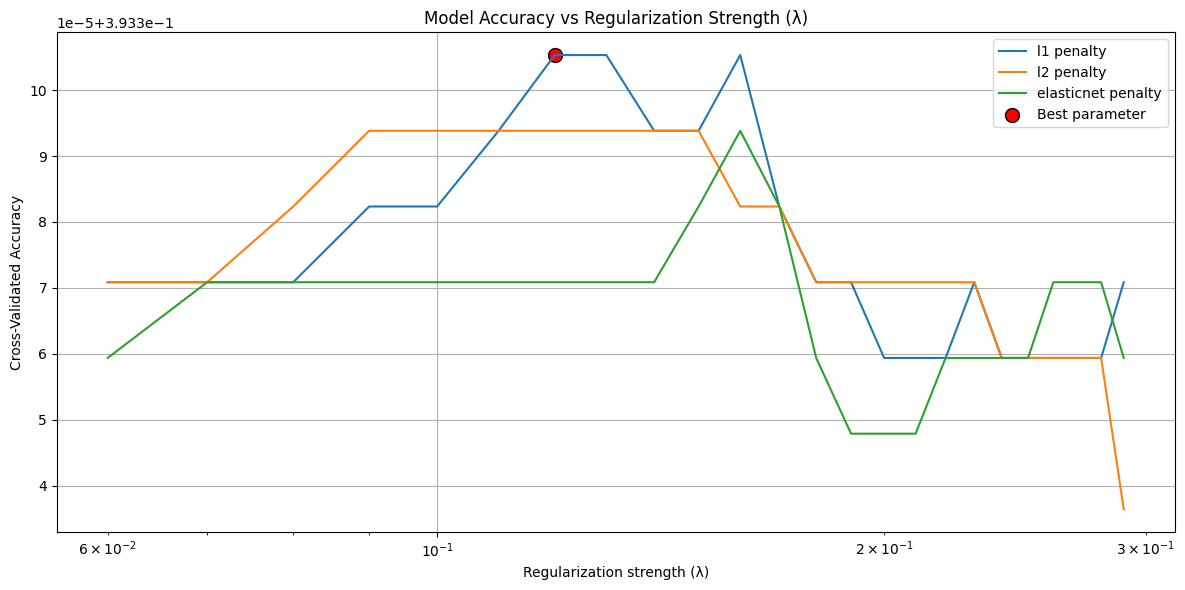

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score

df_sensor = pd.read_csv("datasets/assignTTSWING_sensor_only.csv")
X = df_sensor.drop(columns=['playYears'])
y = df_sensor['playYears']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


lambdas = [0.05 + 0.01 * n for n in range(1, 25)] 
C_values = [1 / l for l in lambdas]

param_grid = [
    {'penalty': ['l1'], 'solver': ['saga'], 'C': C_values, 'class_weight': ['balanced'], 'max_iter': [1000]},
    {'penalty': ['l2'], 'solver': ['saga'], 'C': C_values, 'class_weight': ['balanced'], 'max_iter': [1000]},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': C_values, 'class_weight': ['balanced'], 'l1_ratio': [0.5], 'max_iter': [1000]}
]


grid = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    scoring='accuracy',  
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_scaled, y)


print("Best parameters found:")
print(grid.best_params_)
print(f"Best score: {grid.best_score_:.4f}")


results = pd.DataFrame(grid.cv_results_)


results['lambda'] = 1 / results['param_C'].astype(float)


plt.figure(figsize=(12, 6))

for penalty in results['param_penalty'].unique():
    subset = results[results['param_penalty'] == penalty].sort_values(by='lambda')
    plt.plot(
        subset['lambda'],
        subset['mean_test_score'],
        label=f"{penalty} penalty"
    )


best_row = results.loc[results['rank_test_score'].idxmin()]
plt.scatter(
    best_row['lambda'],
    best_row['mean_test_score'],
    color='red',
    s=100,
    edgecolors='black',
    label='Best parameter'
)

plt.xscale('log')  
plt.xlabel("Regularization strength (λ)")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Model Accuracy vs Regularization Strength (λ)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
from sklearn.metrics import f1_score, make_scorer
f1_macro = make_scorer(f1_score, average='macro')
